In [71]:
import pandas as pd
df = pd.read_json('../csv/acn_transfer.json')
df['connectionTime'] = pd.to_datetime(df['connectionTime'], format='mixed', utc=True)
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], format='mixed', utc=True)
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], format='mixed', utc=True)
xx = df['userInputs'].apply(lambda x:x[-1] if isinstance(x,list) and len(x)>0 else None)
flod  = pd.json_normalize(xx)
df = pd.concat([df,flod],axis=1)
df['requestedDeparture'] = pd.to_datetime(df['requestedDeparture'],format='mixed',utc=True)
df['modifiedAt'] = pd.to_datetime(df['modifiedAt'],format='mixed',utc=True)
df

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,userID,kmRequested,WhPerKM
0,5dd1f434f9af8b2dec178075,39,2019-11-01 18:11:18+00:00,2019-11-02 02:55:36+00:00,2019-11-02 01:16:41+00:00,14.101,2_39_78_360_2019-11-01 18:11:18.415605,2,CA-322,2-39-78-360,...,400.0,24.0,60.0,443.0,2019-11-01 18:11:28+00:00,True,2019-11-02 01:34:18+00:00,676.0,96.5604,248.549095
1,5dd1f434f9af8b2dec178076,39,2019-11-01 18:30:34+00:00,2019-11-01 22:15:42+00:00,2019-11-01 22:15:39+00:00,6.962,2_39_78_367_2019-11-01 18:30:33.896233,2,CA-494,2-39-78-367,...,375.0,15.0,40.0,378.0,2019-11-01 18:31:47+00:00,True,2019-11-02 00:48:34+00:00,3447.0,64.3736,233.014776
2,5dd1f434f9af8b2dec178077,39,2019-11-01 18:55:24+00:00,2019-11-01 19:33:16+00:00,2019-11-01 19:33:12+00:00,2.394,2_39_78_361_2019-11-01 18:55:23.831102,2,CA-493,2-39-78-361,...,400.0,36.0,90.0,311.0,2019-11-01 18:55:48+00:00,True,2019-11-02 00:06:24+00:00,832.0,144.8406,248.549095
3,5dd1f434f9af8b2dec178078,39,2019-11-01 19:10:30+00:00,2019-11-02 05:12:26+00:00,2019-11-01 20:15:26+00:00,2.160,2_39_123_23_2019-11-01 19:10:29.559896,2,CA-313,2-39-123-23,...,400.0,16.0,40.0,291.0,2019-11-01 19:10:57+00:00,True,2019-11-02 00:01:30+00:00,1082.0,64.3736,248.549095
4,5dd1f434f9af8b2dec178079,39,2019-11-01 19:44:41+00:00,2019-11-01 23:22:16+00:00,2019-11-01 22:20:49+00:00,6.756,2_39_78_366_2019-11-01 19:38:12.363403,2,CA-323,2-39-78-366,...,400.0,8.0,20.0,60.0,2019-11-01 19:44:41+00:00,True,2019-11-01 20:44:41+00:00,1124.0,32.1868,248.549095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,61550519f9af8b76960e169a,39,2021-09-13 21:12:53+00:00,2021-09-14 00:25:36+00:00,2021-09-13 21:41:31+00:00,2.285,2_39_89_25_2021-09-13 21:12:53.318460,2,CA-315,2-39-89-25,...,286.0,28.6,100.0,480.0,2021-09-13 21:13:32+00:00,True,2021-09-14 05:12:53+00:00,431.0,160.9340,177.712603
6901,61550519f9af8b76960e169b,39,2021-09-13 21:17:04+00:00,2021-09-14 01:01:49+00:00,2021-09-13 23:18:07+00:00,6.715,2_39_123_23_2021-09-13 21:16:44.026068,2,CA-313,2-39-123-23,...,460.0,11.5,25.0,150.0,2021-09-13 21:17:49+00:00,True,2021-09-13 23:47:04+00:00,6481.0,40.2335,285.831459
6902,61550519f9af8b76960e169c,39,2021-09-13 22:33:07+00:00,2021-09-13 23:06:55+00:00,NaT,17.720,2_39_81_4550_2021-09-13 22:33:04.543952,2,11900388,2-39-81-4550,...,300.0,30.0,100.0,288.0,2021-09-13 22:33:07+00:00,True,2021-09-14 03:21:07+00:00,3905.0,160.9340,186.411821
6903,61550519f9af8b76960e169d,39,2021-09-13 23:11:12+00:00,2021-09-14 01:43:11+00:00,2021-09-14 00:13:35+00:00,2.018,2_39_91_437_2021-09-13 23:10:59.528292,2,CA-317,2-39-91-437,...,290.0,5.8,20.0,120.0,2021-09-13 23:11:12+00:00,True,2021-09-14 01:11:12+00:00,1082.0,32.1868,180.198094


In [ ]:
df = df.set_index('connectionTime')
hourly = df.resample('1h').sum(numeric_only=True)
daily = df.resample('1D').sum(numeric_only=True)
weekly = df.resample('1W').sum(numeric_only=True)
half_hourly = df.resample('30min').sum(numeric_only=True)

['CA-322' 'CA-494' 'CA-493' 'CA-313' 'CA-323' 'CA-317' 'CA-304' 'CA-495'
 'CA-307' 'CA-499' 'CA-318' 'CA-316' 'CA-303' 'CA-306' 'CA-490' 'CA-315'
 'CA-512' 'CA-326' 'CA-308' 'CA-212' 'CA-325' 'CA-305' 'CA-309' 'CA-312'
 'CA-492' 'CA-311' 'CA-491' 'CA-327' 'CA-489' 'CA-324' 'CA-319' 'CA-496'
 'CA-497' 'CA-321' 'CA-314' 'CA-498' 'CA-320' 'CA-501' 'CA-500' 'CA-513'
 'CA-502' 'CA-503' 'CA-310' 'CA-505' 'CA-511' 'CA-506' 'CA-507' 'CA-504'
 'CA-508' 'CA-509' 'CA-510' 'CA-149' 'CA-213' '11900388' 'CA-148']


<Axes: xlabel='spaceID'>

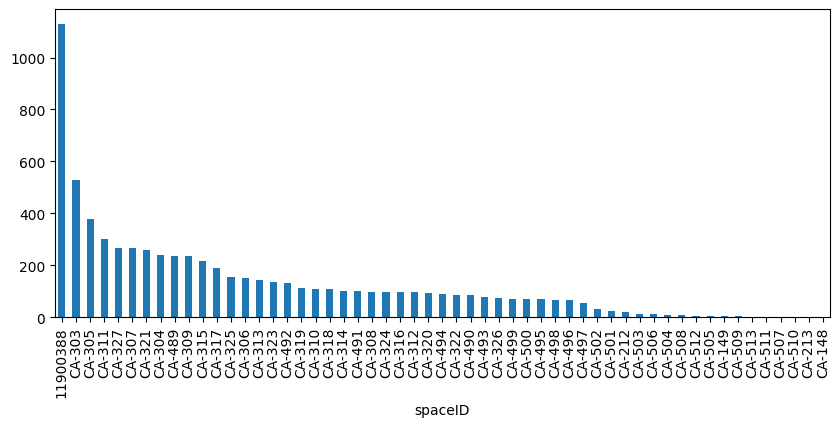

In [49]:
print(df['spaceID'].unique())
df['spaceID'].value_counts().plot(kind='bar', figsize=(10, 4))

In [41]:
#전처리 테이블 생성
sort = df[['connectionTime', 'doneChargingTime','kWhDelivered','kWhRequested','WhPerMile','milesRequested','requestedDeparture','disconnectTime']].copy()
sort[['disconnectReasone','EVESstatus','StationId','EVESID']] = None
sort

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime,disconnectReasone,EVESstatus,StationId,EVESID
0,2019-11-01 18:11:18+00:00,2019-11-02 01:16:41+00:00,14.101,24.0,400.0,60.0,2019-11-02 01:34:18+00:00,2019-11-02 02:55:36+00:00,None,None,None,None
1,2019-11-01 18:30:34+00:00,2019-11-01 22:15:39+00:00,6.962,15.0,375.0,40.0,2019-11-02 00:48:34+00:00,2019-11-01 22:15:42+00:00,None,None,None,None
2,2019-11-01 18:55:24+00:00,2019-11-01 19:33:12+00:00,2.394,36.0,400.0,90.0,2019-11-02 00:06:24+00:00,2019-11-01 19:33:16+00:00,None,None,None,None
3,2019-11-01 19:10:30+00:00,2019-11-01 20:15:26+00:00,2.160,16.0,400.0,40.0,2019-11-02 00:01:30+00:00,2019-11-02 05:12:26+00:00,None,None,None,None
4,2019-11-01 19:44:41+00:00,2019-11-01 22:20:49+00:00,6.756,8.0,400.0,20.0,2019-11-01 20:44:41+00:00,2019-11-01 23:22:16+00:00,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
6900,2021-09-13 21:12:53+00:00,2021-09-13 21:41:31+00:00,2.285,28.6,286.0,100.0,2021-09-14 05:12:53+00:00,2021-09-14 00:25:36+00:00,None,None,None,None
6901,2021-09-13 21:17:04+00:00,2021-09-13 23:18:07+00:00,6.715,11.5,460.0,25.0,2021-09-13 23:47:04+00:00,2021-09-14 01:01:49+00:00,None,None,None,None
6902,2021-09-13 22:33:07+00:00,NaT,17.720,30.0,300.0,100.0,2021-09-14 03:21:07+00:00,2021-09-13 23:06:55+00:00,None,None,None,None
6903,2021-09-13 23:11:12+00:00,2021-09-14 00:13:35+00:00,2.018,5.8,290.0,20.0,2021-09-14 01:11:12+00:00,2021-09-14 01:43:11+00:00,None,None,None,None


In [ ]:
#충전기에 꼽았지만 충전을 요청하지 않은 경우 결측치 0처리
sort[['kWhRequested','WhPerMile','milesRequested']] = sort[['kWhRequested','WhPerMile','milesRequested']].fillna(0)

In [ ]:
#충전기에 꼽고 출발시간을 입력하지 않은 경우
#분석 결과 = 충전 요청이 없음
sort = sort.drop(index=[5158,4684,5924]) #충전량 이상치 3건 33, 46, 24 제거
sort[sort[['requestedDeparture']].isna().any(axis=1)]

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime
5,2019-11-01 19:50:43+00:00,2019-11-01 23:47:56+00:00,0.878,0.0,0.0,0.0,NaT,2019-11-02 00:06:10+00:00
8,2019-11-01 20:56:34+00:00,2019-11-01 21:19:56+00:00,0.625,0.0,0.0,0.0,NaT,2019-11-01 21:19:59+00:00
17,2019-11-02 02:40:18+00:00,2019-11-02 03:10:58+00:00,0.891,0.0,0.0,0.0,NaT,2019-11-02 03:53:01+00:00
19,2019-11-02 16:27:08+00:00,2019-11-02 16:57:36+00:00,0.846,0.0,0.0,0.0,NaT,2019-11-02 18:00:43+00:00
21,2019-11-02 17:13:11+00:00,2019-11-02 17:43:31+00:00,0.881,0.0,0.0,0.0,NaT,2019-11-02 20:06:46+00:00
...,...,...,...,...,...,...,...,...
6807,2021-09-10 02:29:25+00:00,2021-09-10 05:03:33+00:00,0.907,0.0,0.0,0.0,NaT,2021-09-10 05:24:15+00:00
6809,2021-09-10 02:53:50+00:00,2021-09-10 03:11:18+00:00,0.501,0.0,0.0,0.0,NaT,2021-09-10 03:11:24+00:00
6841,2021-09-10 23:03:07+00:00,2021-09-11 01:35:38+00:00,0.904,0.0,0.0,0.0,NaT,2021-09-11 04:28:38+00:00
6848,2021-09-11 03:03:40+00:00,2021-09-11 03:34:15+00:00,0.902,0.0,0.0,0.0,NaT,2021-09-11 04:18:40+00:00


In [ ]:
#충전기를 꼽았지만 충전요청도 없고 출발시간도 없음 
#분석결과 충전량도 미미 = 저전력충전모드 예상 방전 예방, 차량통신등을 위한 전력만 들어감
mask = sort[['doneChargingTime', 'requestedDeparture']].isna().all(axis=1)
sort.loc[mask, 'doneChargingTime'] = sort.loc[mask, 'disconnectTime']
sort[mask]

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime
1381,2019-12-30 18:09:38+00:00,2019-12-30 19:37:50+00:00,0.925,0.0,0.0,0.0,NaT,2019-12-30 19:37:50+00:00
1608,2020-01-11 16:36:16+00:00,2020-01-11 22:53:20+00:00,0.980,0.0,0.0,0.0,NaT,2020-01-11 22:53:20+00:00
1615,2020-01-12 17:05:48+00:00,2020-01-12 17:28:19+00:00,0.675,0.0,0.0,0.0,NaT,2020-01-12 17:28:19+00:00
1987,2020-01-24 16:01:14+00:00,2020-01-24 18:15:33+00:00,0.848,0.0,0.0,0.0,NaT,2020-01-24 18:15:33+00:00
2003,2020-01-24 18:51:25+00:00,2020-01-24 20:54:14+00:00,0.838,0.0,0.0,0.0,NaT,2020-01-24 20:54:14+00:00
...,...,...,...,...,...,...,...,...
6202,2021-08-11 14:35:44+00:00,2021-08-11 17:12:26+00:00,0.883,0.0,0.0,0.0,NaT,2021-08-11 17:12:26+00:00
6237,2021-08-12 18:03:55+00:00,2021-08-12 23:12:23+00:00,0.854,0.0,0.0,0.0,NaT,2021-08-12 23:12:23+00:00
6405,2021-08-21 01:02:04+00:00,2021-08-21 02:09:26+00:00,0.897,0.0,0.0,0.0,NaT,2021-08-21 02:09:26+00:00
6634,2021-09-01 21:00:17+00:00,2021-09-01 22:50:46+00:00,0.895,0.0,0.0,0.0,NaT,2021-09-01 22:50:46+00:00


In [ ]:
mask = (sort['doneChargingTime'].isna()) & (sort['kWhRequested'] >= 10)
filtered = sort[mask]
filtered

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime
1382,2019-12-30 18:55:22+00:00,NaT,13.440,21.0,420.0,50.0,2019-12-30 23:42:22+00:00,2019-12-30 21:05:28+00:00
1607,2020-01-11 14:27:47+00:00,NaT,15.707,32.0,400.0,80.0,2020-01-12 01:05:47+00:00,2020-01-11 18:35:08+00:00
1609,2020-01-11 17:30:49+00:00,NaT,17.409,17.5,250.0,70.0,2020-01-12 05:02:49+00:00,2020-01-11 22:05:13+00:00
1611,2020-01-11 22:48:52+00:00,NaT,8.840,20.0,400.0,50.0,2020-01-11 23:51:52+00:00,2020-01-12 01:19:28+00:00
1612,2020-01-11 22:54:12+00:00,NaT,24.904,25.0,250.0,100.0,2020-01-12 04:49:12+00:00,2020-01-12 03:52:11+00:00
...,...,...,...,...,...,...,...,...
6875,2021-09-13 06:31:02+00:00,NaT,44.996,18.5,370.0,50.0,2021-09-13 08:55:02+00:00,2021-09-13 08:00:26+00:00
6894,2021-09-13 18:04:33+00:00,NaT,19.704,29.9,299.0,100.0,2021-09-14 02:04:33+00:00,2021-09-13 18:31:32+00:00
6899,2021-09-13 20:26:50+00:00,NaT,49.136,25.9,370.0,70.0,2021-09-14 04:26:50+00:00,2021-09-13 21:56:03+00:00
6902,2021-09-13 22:33:07+00:00,NaT,17.720,30.0,300.0,100.0,2021-09-14 03:21:07+00:00,2021-09-13 23:06:55+00:00


In [ ]:
sort[sort[['doneChargingTime']].isna().any(axis=1)]

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime
1380,2019-12-30 17:43:48+00:00,NaT,5.814,8.0,400.0,20.0,2019-12-30 18:13:48+00:00,2019-12-30 19:47:48+00:00
1381,2019-12-30 18:09:38+00:00,NaT,0.925,0.0,0.0,0.0,NaT,2019-12-30 19:37:50+00:00
1382,2019-12-30 18:55:22+00:00,NaT,13.440,21.0,420.0,50.0,2019-12-30 23:42:22+00:00,2019-12-30 21:05:28+00:00
1607,2020-01-11 14:27:47+00:00,NaT,15.707,32.0,400.0,80.0,2020-01-12 01:05:47+00:00,2020-01-11 18:35:08+00:00
1608,2020-01-11 16:36:16+00:00,NaT,0.980,0.0,0.0,0.0,NaT,2020-01-11 22:53:20+00:00
...,...,...,...,...,...,...,...,...
6875,2021-09-13 06:31:02+00:00,NaT,44.996,18.5,370.0,50.0,2021-09-13 08:55:02+00:00,2021-09-13 08:00:26+00:00
6894,2021-09-13 18:04:33+00:00,NaT,19.704,29.9,299.0,100.0,2021-09-14 02:04:33+00:00,2021-09-13 18:31:32+00:00
6899,2021-09-13 20:26:50+00:00,NaT,49.136,25.9,370.0,70.0,2021-09-14 04:26:50+00:00,2021-09-13 21:56:03+00:00
6902,2021-09-13 22:33:07+00:00,NaT,17.720,30.0,300.0,100.0,2021-09-14 03:21:07+00:00,2021-09-13 23:06:55+00:00


In [8]:
# Calculate the time difference and get the time part (as timedelta, then convert to seconds/hours/minutes if needed)
time_diff = sort['disconnectTime'][0] - sort['connectionTime'][0]
# To get the duration as hours, minutes, seconds:
hours, remainder = divmod(time_diff.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
(time_diff, hours, minutes, seconds, remainder)

(Timedelta('0 days 08:44:18'), 8.0, 44.0, 18.0, 2658.0)

In [ ]:
# Calculate the time difference and get the time part (as timedelta, then convert to seconds/hours/minutes if needed)
time_diff = sort['disconnectTime'][0] - sort['connectionTime'][0]
# To get the duration as hours, minutes, seconds:
hours, remainder = divmod(time_diff.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
(time_diff, hours, minutes, seconds)

(Timedelta('0 days 08:44:18'), 8.0, 44.0, 18.0)

In [ ]:
# datetime → timestamp + 결측은 0으로

sort['requestedDeparture_ts'] = sort['requestedDeparture'].apply(
    lambda x: int(x.timestamp()) if isinstance(x, pd.Timestamp) else 0
).astype('int64')
sort

,connectionTime,doneChargingTime,kWhDelivered,kWhRequested,WhPerMile,milesRequested,requestedDeparture,disconnectTime,requestedDeparture_ts
0,2019-11-01 18:11:18+00:00,2019-11-02 01:16:41+00:00,14.101,24.0,400.0,60.0,2019-11-02 01:34:18+00:00,2019-11-02 02:55:36+00:00,1572658458
1,2019-11-01 18:30:34+00:00,2019-11-01 22:15:39+00:00,6.962,15.0,375.0,40.0,2019-11-02 00:48:34+00:00,2019-11-01 22:15:42+00:00,1572655714
2,2019-11-01 18:55:24+00:00,2019-11-01 19:33:12+00:00,2.394,36.0,400.0,90.0,2019-11-02 00:06:24+00:00,2019-11-01 19:33:16+00:00,1572653184
3,2019-11-01 19:10:30+00:00,2019-11-01 20:15:26+00:00,2.160,16.0,400.0,40.0,2019-11-02 00:01:30+00:00,2019-11-02 05:12:26+00:00,1572652890
4,2019-11-01 19:44:41+00:00,2019-11-01 22:20:49+00:00,6.756,8.0,400.0,20.0,2019-11-01 20:44:41+00:00,2019-11-01 23:22:16+00:00,1572641081
...,...,...,...,...,...,...,...,...,...
6900,2021-09-13 21:12:53+00:00,2021-09-13 21:41:31+00:00,2.285,28.6,286.0,100.0,2021-09-14 05:12:53+00:00,2021-09-14 00:25:36+00:00,1631596373
6901,2021-09-13 21:17:04+00:00,2021-09-13 23:18:07+00:00,6.715,11.5,460.0,25.0,2021-09-13 23:47:04+00:00,2021-09-14 01:01:49+00:00,1631576824
6902,2021-09-13 22:33:07+00:00,NaT,17.720,30.0,300.0,100.0,2021-09-14 03:21:07+00:00,2021-09-13 23:06:55+00:00,1631589667
6903,2021-09-13 23:11:12+00:00,2021-09-14 00:13:35+00:00,2.018,5.8,290.0,20.0,2021-09-14 01:11:12+00:00,2021-09-14 01:43:11+00:00,1631581872


C:\Users\3\AppData\Local\Temp\ipykernel_133820\3946820502.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_kwh = df.set_index('connectionTime')['kWhDelivered'].resample('1H').sum()


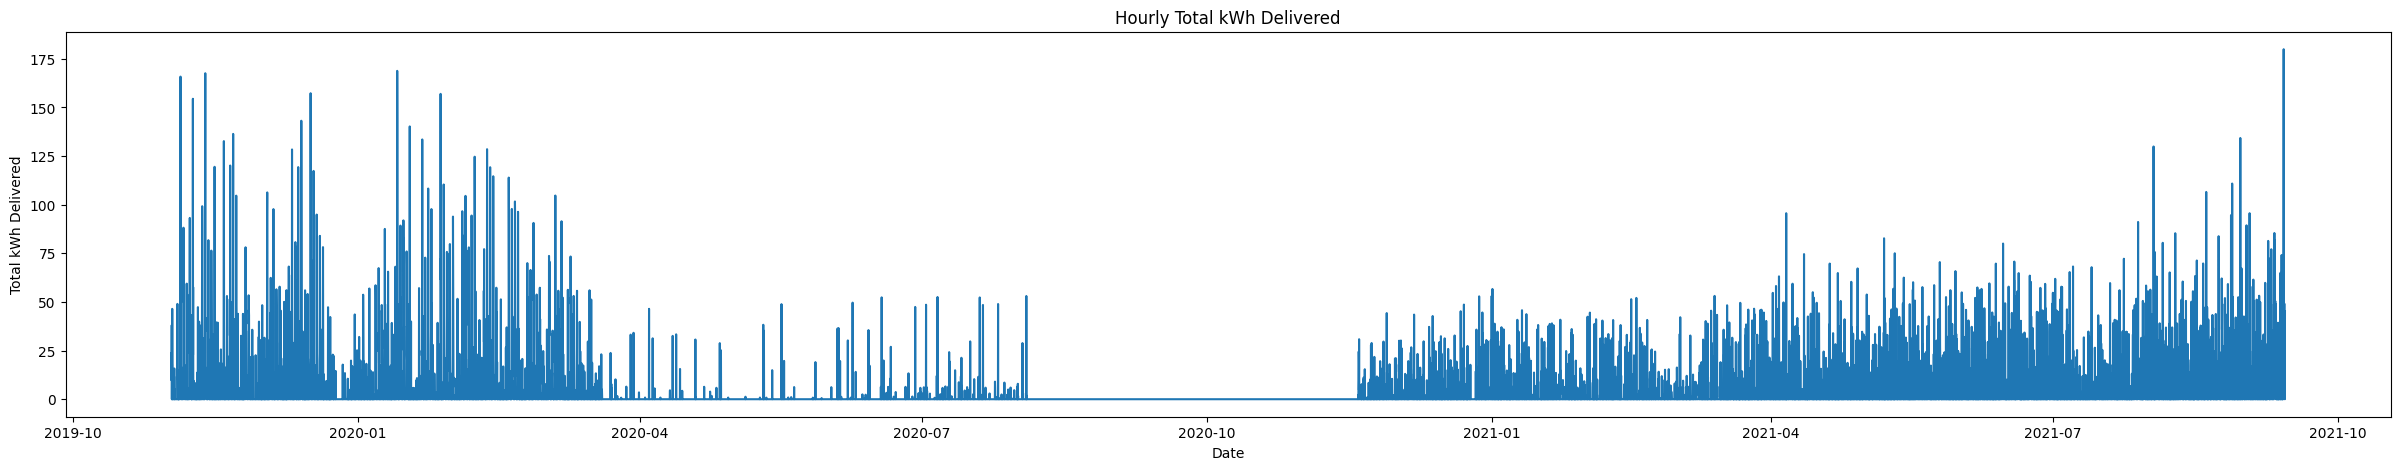

In [26]:
import matplotlib.pyplot as plt

# Set connectionTime as index for resampling
hourly_kwh = df.set_index('connectionTime')['kWhDelivered'].resample('1H').sum()

plt.figure(figsize=(30,5))
plt.plot(hourly_kwh.index, hourly_kwh)
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.title('Hourly Total kWh Delivered')
plt.show()

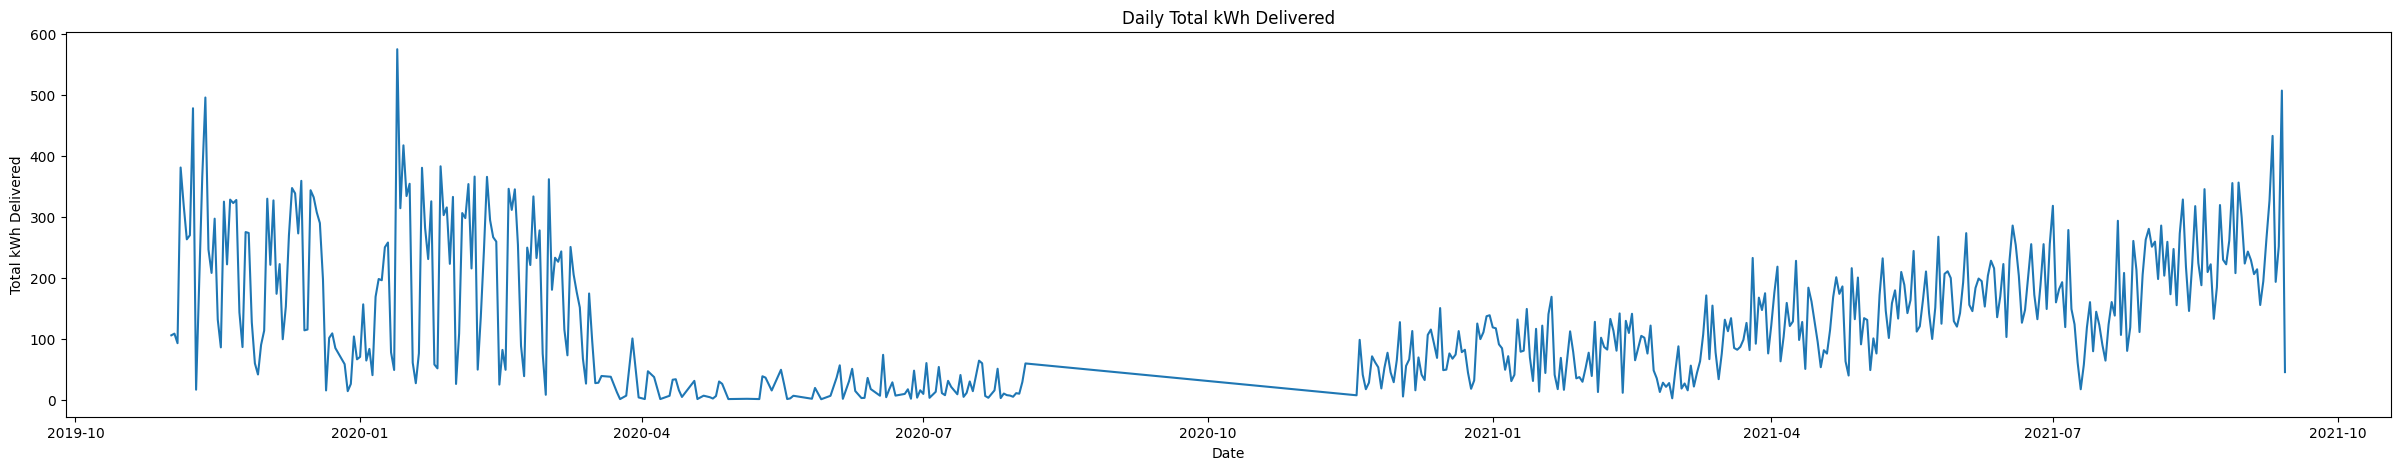

In [27]:
import matplotlib.pyplot as plt

# Group by date and sum kWh delivered per day
daily_kwh = df.groupby(df['connectionTime'].dt.date)['kWhDelivered'].sum()

plt.figure(figsize=(30,5))
plt.plot(daily_kwh.index, daily_kwh.values)
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.title('Daily Total kWh Delivered')
plt.show()

In [ ]:
import random
from datetime import datetime, timedelta

# 고정 seed로 재현성 확보
random.seed(42)

# OCPP 및 OCPI 예시 데이터 생성
ocpp_entries = []
ocpi_entries = []

for i in range(10):
    txn_id = f"TXN{i+1000}"
    id_token = f"TOKEN_{random.randint(100000, 999999)}"
    id_type = random.choice(["ISO14443", "ISO15693", "E_MAID", "APP_USER", "LOCAL"])
    meter_start = random.randint(100000, 500000)
    energy_kwh = round(random.uniform(0.3, 2.5), 2)|
    meter_stop = meter_start + int(energy_kwh * 1000)
    charging_start = datetime(2025, 6, 25, 9, 0) + timedelta(minutes=i*15)
    charging_end = charging_start + timedelta(minutes=random.randint(15, 40))
    reason = random.choice([
        "EVDisconnected", "Remote", "DeAuthorized", "EmergencyStop",
        "Timeout", "Local", "EnergyLimitReached", "PowerLimitReached"
    ])
    status = random.choice(["Charging", "Available", "Faulted", "SuspendedEV", "SuspendedEVSE"])
    voltage = random.choice([220, 230, 380, 400, 450])
    current = random.randint(10, 200)
    power = round((voltage * current) / 1000, 2)
    temperature = round(random.uniform(30.0, 95.0), 1)
    auth_status = random.choice(["Accepted", "Blocked", "Expired", "Invalid"])
    cert_status = random.choice(["Valid", "Invalid", "Expired"])
    error_code = random.choice(["NoError", "OverTemperature", "PowerLoss", "GroundFailure", "ConnectorLockFailure"])
    network_status = random.choice(["Online", "Offline", "Unknown"])
    rssi = random.randint(-90, -30)

    ocpp_entries.append({
        "transaction.transactionId": txn_id,
        "transaction.idToken.idToken": id_token,
        "transaction.idToken.type": id_type,
        "transaction.meterStart": meter_start,
        "transaction.meterStop": meter_stop,
        "transaction.energyDelivered_kWh": energy_kwh,
        "transaction.chargingStart": charging_start.isoformat() + "Z",
        "transaction.chargingEnd": charging_end.isoformat() + "Z",
        "transaction.reason": reason,
        "connector.status": status,
        "connector.voltage": voltage,
        "connector.current": current,
        "connector.power": power,
        "connector.temperature": temperature,
        "authorization.status": auth_status,
        "authorization.certificateStatus": cert_status,
        "diagnostics.errorCode": error_code,
        "diagnostics.networkStatus": network_status,
        "diagnostics.rssi": rssi
    })

    ocpi_entries.append({
        "cdr_id": f"CDR_{txn_id}",
        "session_id": txn_id,
        "auth_id": id_token,
        "token_type": "RFID" if "ISO" in id_type else "APP_USER",
        "location_id": f"LOC_{random.randint(100, 999)}",
        "evse_uid": f"EVSE_{random.randint(1000, 9999)}",
        "connector_id": 1,
        "start_date_time": charging_start.isoformat() + "Z",
        "end_date_time": charging_end.isoformat() + "Z",
        "meter_start": meter_start,
        "meter_stop": meter_stop,
        "total_energy": energy_kwh,
        "currency": "KRW",
        "stop_reason": reason,
        "tariff_id": f"TARIFF_{random.randint(1, 10)}",
        "signed": random.choice([True, False]),
        "last_updated": (charging_end + timedelta(minutes=1)).isoformat() + "Z"
    })

ocpp_df = pd.DataFrame(ocpp_entries)
ocpi_df = pd.DataFrame(ocpi_entries)

ocpp_df

,transaction.transactionId,transaction.idToken.idToken,transaction.idToken.type,transaction.meterStart,transaction.meterStop,transaction.energyDelivered_kWh,transaction.chargingStart,transaction.chargingEnd,transaction.reason,connector.status,connector.voltage,connector.current,connector.power,connector.temperature,authorization.status,authorization.certificateStatus,diagnostics.errorCode,diagnostics.networkStatus,diagnostics.rssi
0,TXN1000,TOKEN_770487,ISO14443,113112,115042,1.93,2025-06-25T09:00:00Z,2025-06-25T09:22:00Z,EmergencyStop,Available,220,183,40.26,78.1,Accepted,Expired,GroundFailure,Online,-89
1,TXN1001,TOKEN_688508,ISO15693,475400,477130,1.73,2025-06-25T09:15:00Z,2025-06-25T09:47:00Z,EnergyLimitReached,Available,400,160,64.00,48.1,Accepted,Valid,GroundFailure,Offline,-73
2,TXN1002,TOKEN_197251,APP_USER,150707,151797,1.09,2025-06-25T09:30:00Z,2025-06-25T09:56:00Z,Timeout,Charging,400,147,58.80,38.1,Invalid,Valid,ConnectorLockFailure,Offline,-37
3,TXN1003,TOKEN_838797,ISO14443,124025,125775,1.75,2025-06-25T09:45:00Z,2025-06-25T10:24:00Z,Timeout,Charging,230,35,8.05,54.7,Invalid,Expired,PowerLoss,Online,-67
4,TXN1004,TOKEN_738720,ISO15693,380043,381943,1.90,2025-06-25T10:00:00Z,2025-06-25T10:20:00Z,PowerLimitReached,SuspendedEV,380,173,65.74,74.7,Blocked,Expired,PowerLoss,Online,-76
5,TXN1005,TOKEN_380746,ISO14443,210615,212925,2.31,2025-06-25T10:15:00Z,2025-06-25T10:48:00Z,Local,Available,400,111,44.40,87.5,Invalid,Valid,PowerLoss,Online,-75
6,TXN1006,TOKEN_711878,APP_USER,289790,290570,0.78,2025-06-25T10:30:00Z,2025-06-25T10:49:00Z,PowerLimitReached,Charging,220,38,8.36,39.9,Blocked,Expired,GroundFailure,Unknown,-86
7,TXN1007,TOKEN_654816,E_MAID,390049,392239,2.19,2025-06-25T10:45:00Z,2025-06-25T11:00:00Z,Remote,SuspendedEVSE,380,174,66.12,52.1,Expired,Invalid,OverTemperature,Offline,-90
8,TXN1008,TOKEN_632342,ISO14443,427837,428797,0.96,2025-06-25T11:00:00Z,2025-06-25T11:35:00Z,EmergencyStop,Available,380,51,19.38,65.1,Accepted,Expired,PowerLoss,Offline,-89
9,TXN1009,TOKEN_160738,ISO15693,397458,399838,2.38,2025-06-25T11:15:00Z,2025-06-25T11:32:00Z,PowerLimitReached,Charging,450,42,18.90,38.3,Invalid,Expired,OverTemperature,Offline,-57


In [ ]:
# OCPI 예제 데이터에 이어서 위치(locations), 요금(tariffs), CDR 데이터를 생성

# locations: 충전소 정보
locations = []
tariffs = []
cdrs = []

for i, ocpi_row in enumerate(ocpi_df.itertuples()):
    location_id = ocpi_row.location_id
    evse_uid = ocpi_row.evse_uid
    tariff_id = ocpi_row.tariff_id

    # Location 정보
    locations.append({
        "location_id": location_id,
        "name": f"충전소 {i+1}",
        "evse_uid": evse_uid,
        "address": f"서울특별시 중구 세종대로 {10+i}",
        "city": "서울",
        "postal_code": f"045{i}0",
        "country_code": "KR",
        "latitude": round(37.5665 + i*0.001, 6),
        "longitude": round(126.9780 + i*0.001, 6),
        "type": "PUBLIC"
    })

    # Tariff 정보
    tariffs.append({
        "tariff_id": tariff_id,
        "currency": "KRW",
        "elements": [
            {"price_components": [{"type": "ENERGY", "price": round(250 + i*10, 2), "step_size": 1}]}
        ]
    })

    # CDR 정보
    cdrs.append({
        "cdr_id": ocpi_row.cdr_id,
        "location_id": location_id,
        "evse_uid": evse_uid,
        "connector_id": ocpi_row.connector_id,
        "auth_id": ocpi_row.auth_id,
        "start_date_time": ocpi_row.start_date_time,
        "end_date_time": ocpi_row.end_date_time,
        "meter_start": ocpi_row.meter_start,
        "meter_stop": ocpi_row.meter_stop,
        "total_energy_kWh": ocpi_row.total_energy,
        "currency": ocpi_row.currency,
        "tariff_id": tariff_id,
        "total_cost_KRW": round(ocpi_row.total_energy * (250 + i*10), 2),
        "stop_reason": ocpi_row.stop_reason,
        "last_updated": ocpi_row.last_updated
    })

# 데이터프레임 생성
locations_df = pd.DataFrame(locations)
tariffs_df = pd.DataFrame(tariffs)
cdrs_df = pd.DataFrame(cdrs)

# 파일로 저장
locations_path = "../data/csv/ocpi_locations.csv"
tariffs_path = "../data/csv/ocpi_tariffs.csv"
cdrs_path = "../data/csv/ocpi_cdrs.csv"

locations_df.to_csv(locations_path, index=False)
tariffs_df.to_csv(tariffs_path, index=False)
cdrs_df.to_csv(cdrs_path, index=False)

locations_path, tariffs_path, cdrs_path
